In [628]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import os
from sklearn.metrics import f1_score
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime
from xgboost import XGBClassifier
import seaborn as sns


In [629]:
# Путь к директории с данными

data_dir = '../00_data/track_1/'
extra_data_dir =  '../00_data/1_track_extra_train'
sumbit_dir = '../02_submits/'
preprocessed_dir = '../03_preprocessed_data/'

# Метео
mc = pd.read_csv(data_dir + 'meteo_coord.csv')
mld = pd.read_csv(data_dir + 'meteo_1day.csv')
mlm = pd.read_csv(data_dir + 'meteo_1month.csv')
#m3h = pd.read_csv(data_dir + 'meteo_3hours.csv')
rhv = pd.read_csv(data_dir + 'reference_horiz_visib.csv')
main_df = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')

# Гидро
hc = pd.read_csv(data_dir + 'hydro_coord.csv')
hld = pd.read_csv(data_dir + 'hydro_1day.csv',
                   parse_dates=['date'])
#h1d_extra = pd.read_csv(extra_data_dir + 'hydro_1day.csv',
#                   parse_dates=['date'])

#hld = pd.contact([hld, h1d_extra])
rwc = pd.read_csv(data_dir + 'reference_water_codes.csv')
#os.listdir(data_dir)
all_pressure_data_level_1000 = pd.read_pickle(preprocessed_dir + 'all_pressure_data_level_1000.pkl')

In [630]:
# Проранжировать станции по течению реки
# 3019 Киренск
# 3027 Витим
# 3028 Пелендуй
# 3029 КРЕСТОВСКОЕ 
# 3030 ЛЕНСК 
# 3035 ОЛЕКМИНСК 
# 3041 ПОКРОВСК 
# 3045 ЯКУТСК 
# 3230 БАТАМАЙ 
# 3050 САНГАРЫ 

station_id_ordered = [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045,  3230, 3050]
station_id_rank = range(0, len(station_id_ordered))
station_id_rank = dict(zip(station_id_ordered, station_id_rank))

In [631]:
all_pressure_data_level_1000['station_id'] = all_pressure_data_level_1000['station_id'].astype(int)
all_pressure_data_level_1000 = all_pressure_data_level_1000.reset_index()
all_pressure_data_level_1000 = all_pressure_data_level_1000.drop(['lat', 'lon'], axis = 1)
all_pressure_data_level_1000['date']= all_pressure_data_level_1000['time'].dt.date.astype(str)
all_pressure_data_level_1000 = all_pressure_data_level_1000[all_pressure_data_level_1000['station_id'].isin(station_id_ordered)]

In [632]:
all_pressure_data_level_1000[(all_pressure_data_level_1000['station_id'] == 3019) &
(all_pressure_data_level_1000['date'] == '2015-12-01')]

,time,hgt,station_id,uwnd,vwnd,shum,rhum,omega,date
425016,2015-12-01 00:00:00,141.0,3019,4.000000,0.100002,0.00251,100.0,0.025,2015-12-01
425017,2015-12-01 06:00:00,168.0,3019,5.300002,0.800003,0.00223,97.0,-0.018,2015-12-01
425018,2015-12-01 12:00:00,192.0,3019,3.200000,0.600003,0.00194,100.0,0.033,2015-12-01
425019,2015-12-01 18:00:00,234.0,3019,3.000000,-0.699998,0.00140,97.0,-0.015,2015-12-01


In [633]:
all_pressure_data_level_1000['date']

0         1985-01-01
1         1985-01-01
2         1985-01-01
3         1985-01-01
4         1985-01-02
             ...    
517195    2021-05-25
517196    2021-05-26
517197    2021-05-26
517198    2021-05-26
517199    2021-05-26
Name: date, Length: 517200, dtype: object

# Гидрологические данные

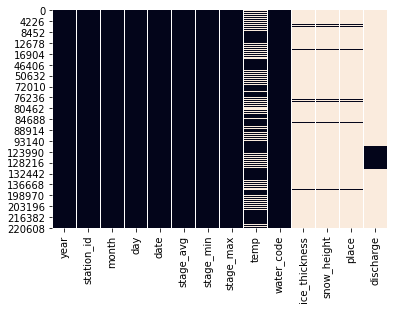

In [634]:
hld = hld[hld['station_id'].isin(station_id_ordered)]

sns.heatmap(hld.isnull(), cbar=False)

В летние месяцы заполнить толщину льда и высоту снена нулем. В остальные дни сделать интерполяцию по дате для каждой станции.

In [635]:
months_with_ice = hld.loc[ hld['ice_thickness'] > 0, 'month'].unique()
hld.loc[~(hld['month'].isin(months_with_ice)), 'ice_thickness'] = 0
hld.loc[~(hld['month'].isin(months_with_ice)), 'snow_height'] = 0
hld = hld.sort_values(['station_id', 'year', 'day'])
hld[['ice_thickness', 'snow_height']] = hld.\
    groupby('station_id')['ice_thickness',  'snow_height'].\
    apply(lambda group: group.interpolate(method='index'))

C:\Users\omore\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [636]:
hld[['ice_thickness', 'snow_height']] = hld[['ice_thickness', 'snow_height']].fillna(method='bfill', limit=20)

Пропущенную температуру воды заполним нулем

In [637]:
hld['temp'] = hld['temp'].fillna(0)

Place заполнить нулем в летние месяцы и паддингом назад в остальные

In [638]:
hld.loc[~(hld['month'].isin(months_with_ice)), 'place'] = 0
hld['place'] = hld['place'].fillna(method='bfill', limit=20)

In [639]:
hld = hld.drop(['discharge'], axis = 1)

# Метеорологические данные

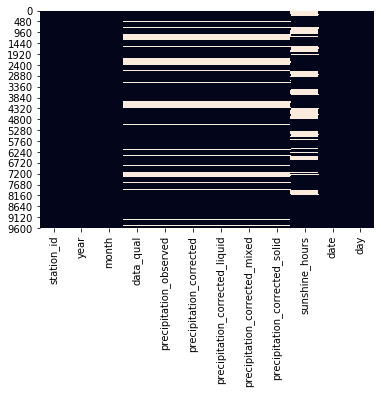

In [640]:
mlm = mlm.sort_values(['station_id', 'year', 'month'])

sns.heatmap(mlm.isnull(), cbar=False)

In [641]:
mlm = mlm.sort_values(['station_id', 'year', 'month'])
num_cols = ['precipitation_observed',
            'precipitation_corrected', 
            'precipitation_corrected_liquid',
           'precipitation_corrected_mixed',
           'precipitation_corrected_solid',
           'sunshine_hours']
mlm[num_cols] = mlm[num_cols + ['station_id']].groupby('station_id').\
    apply(lambda group: group.interpolate(method='index')).drop('station_id', axis = 1)


In [642]:
mlm[num_cols + ['station_id']].groupby('station_id').\
    apply(lambda group: group.interpolate(method='index'))

,precipitation_observed,precipitation_corrected,precipitation_corrected_liquid,precipitation_corrected_mixed,precipitation_corrected_solid,sunshine_hours,station_id
0,3.8,5.7,0.0,0.0,5.7,NaN,24538
1,3.6,5.2,0.0,0.0,5.2,NaN,24538
2,21.3,23.6,23.6,0.0,0.0,NaN,24538
3,20.6,20.7,20.7,0.0,0.0,NaN,24538
4,27.5,27.2,25.3,1.1,0.8,NaN,24538
...,...,...,...,...,...,...,...
10055,25.2,23.7,0.0,0.0,23.7,NaN,31137
10056,3.1,2.6,0.0,0.0,2.6,NaN,31137
10057,13.8,14.1,0.0,0.0,14.1,NaN,31137
10058,18.3,17.5,0.0,0.0,17.5,NaN,31137


In [643]:
mlm = mlm.fillna(method='bfill', limit=20)


In [644]:
#mld = mld.sort_values(['station_id', 'year', 'month'])

#sns.heatmap(mld.isnull(), cbar=False)

In [645]:
# sns.heatmap(mlm.isnull(), cbar=False)

In [646]:
# sns.heatmap(m3h.isnull(), cbar=False)

In [647]:
# соединим train и test, чтобы фичи генерировались и на тесте тоже
main_df = pd.concat([main_df, test])
main_df['is_test'] = main_df['ice_jam'].isnull()
main_df['station_rank'] = main_df['station_id']
main_df = main_df.replace({"station_rank": station_id_rank})

### Затор в прошлом году в тот же день

In [648]:
main_df['previous_year'] = main_df['year'] - 1
X = main_df.merge(main_df, 
              how = 'left', 
              left_on = ['previous_year', 'day', 'station_id'],
              right_on = ['year', 'day', 'station_id']
             ).drop(['previous_year_x', 'previous_year_y', 'year_y', 'is_test_y'], axis =1
                   ).rename(columns={'year_x':'year', 
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_last_year'              
                              })
main_df = main_df.drop('previous_year', axis = 1)
X.head()

,year,station_id,day,ice_jam,is_test_x,station_rank_x,ice_jam_same_day_last_year,station_rank_y
0,2000,3019,1,0.0,False,0,0.0,0.0
1,2000,3019,2,0.0,False,0,0.0,0.0
2,2000,3019,3,0.0,False,0,0.0,0.0
3,2000,3019,4,0.0,False,0,0.0,0.0
4,2000,3019,5,0.0,False,0,0.0,0.0


### Затор в позапрошлом году в тот же день

In [649]:
X['preprevious_year'] = X['year'] - 2
X = X.merge(main_df.drop('is_test', axis = 1),
              how = 'left', 
              left_on = ['preprevious_year', 'day', 'station_id'],
              right_on = ['year', 'day', 'station_id']
             ).drop(['preprevious_year', 'year_y'], axis =1
                   ).rename(columns={'year_x':'year', 
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_prelast_year',
                 'is_test_x':'is_test'
                              })
X.head()

,year,station_id,day,ice_jam,is_test,station_rank_x,ice_jam_same_day_last_year,station_rank_y,ice_jam_same_day_prelast_year,station_rank
0,2000,3019,1,0.0,False,0,0.0,0.0,NaN,NaN
1,2000,3019,2,0.0,False,0,0.0,0.0,NaN,NaN
2,2000,3019,3,0.0,False,0,0.0,0.0,NaN,NaN
3,2000,3019,4,0.0,False,0,0.0,0.0,NaN,NaN
4,2000,3019,5,0.0,False,0,0.0,0.0,NaN,NaN


### Индикатор - есть ли данные по заторам за прошлый год

In [650]:
X['is_last_year_missing'] = X['ice_jam_same_day_last_year'].isnull()
X['is_prelast_year_missing'] = X['ice_jam_same_day_prelast_year'].isnull()
X = X.fillna(0)

### Количество заторов в прошлом году

In [651]:
X[['n_jams_last_year','n_jams_prelast_year']] = \
    X.groupby(['year', 'station_id'])[['ice_jam_same_day_last_year', 'ice_jam_same_day_prelast_year']]\
    .transform('sum')

## Количество заторов в прошлом по всем годам

In [652]:
ice_jams_per_year = X.groupby(['year', 'station_id'])['ice_jam'].sum().reset_index().drop_duplicates()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year.sort_values(by = 'year').\
    groupby(['station_id'])['ice_jam'].cumsum()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year['n_jams_past'] - ice_jams_per_year['ice_jam']
ice_jams_per_year = ice_jams_per_year.drop('ice_jam', axis = 1)
X = X.merge(ice_jams_per_year, how = 'left', on = ['year', 'station_id'])

In [653]:
# n_same_days_before: how many days are available in the past for a given date
X['n_same_days_before'] = X[['year', 'day', 'station_id']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day']) \
    .cumcount()
X['n_ice_jams_same_days_before'] = X[['year', 'day', 'station_id', 'ice_jam']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day']) \
    ['ice_jam']\
    .cumsum()
X['n_ice_jams_same_days_before'] = X['n_ice_jams_same_days_before'] - X['ice_jam']
X['n_ice_jams_same_days_before_ratio'] = X['n_ice_jams_same_days_before']/X['n_same_days_before']
X = X.fillna(0)

## Разбиение по годам

In [654]:
# Суммарное количество заторов в году
jams_by_year = main_df.groupby('year').sum()['ice_jam'].to_frame().reset_index()
jams_by_year['ice_jam'].describe()

count    35.000000
mean      3.942857
std       4.014260
min       0.000000
25%       0.000000
50%       3.000000
75%       6.000000
max      16.000000
Name: ice_jam, dtype: float64

In [655]:
# Разделим на бины по квартилям
bins = [-1, 3, 5, 8, 16]
jams_by_year['ice_jam_bins'] = pd.cut(jams_by_year['ice_jam'], bins)
X_length = jams_by_year[['year', 'ice_jam']]
y_length = jams_by_year['ice_jam_bins']
y_length.value_counts()

(-1, 3]    18
(3, 5]      7
(5, 8]      6
(8, 16]     4
Name: ice_jam_bins, dtype: int64

In [656]:
# Разделим годы на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X_length, 
                                                    y_length, 
                                                    test_size=0.3,  
                                                    stratify=y_length, 
                                                    random_state=42)

### Feature description

**is_test**:  if is_test = 1 then the row belongs to the test dataset \
**ice_jam_same_day_last_year**: 1 if there were and ice jam on the same day last year \
**ice_jam_same_day_prelast_year**: 1 if there were and ice jam on the same day 2 years ago \
**is_last_year_missing**: 1 is the same day is missing last year \
**is_prelast_year_missing**: 1 is the same day is missing 2 years ago \
**n_jams_last_year**: number of jams last year at the station \
**n_jams_past**: number of jams in the past available data at the station \
**n_same_days_before**: number of same days available in the past \
**n_ice_jams_same_days_before**: number of ice jams ob the same day in the past \
**n_ice_jams_same_days_before_ratio**: n_ice_jams_same_days_before/n_ice_jams_same_days_before

### Соберем фичи из гидроданных

<div class="alert alert-block alert-warning">
Мы не можем использовать данные из будущего: всё, что происходит после заторного периода, относится уже к следующему году.
</div>

In [657]:
# Внесем не темпоральные данные
X = pd.merge(X, hc[['station_id', 
                                'distance_from_source', 
                                'drainage_area', 
                                'z_null']], on='station_id', how='left')

# Возьмем также данные из ежедневных наблюдений
hld.head(1)

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place
4864,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0


In [658]:
# добавим реанализ к гидро данным
hld['date']= hld['date'].astype(str)
hld = hld.merge(all_pressure_data_level_1000.drop('time', axis = 1), on=['station_id', 'date'], how='left')
hld.head()

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place,hgt,uwnd,vwnd,shum,rhum,omega
0,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,226.0,0.100006,1.600006,0.00098,94.000015,0.054998
1,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,230.0,1.400009,3.500015,0.00096,100.000015,0.066998
2,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999
3,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998
4,1985,3019,1,2,1985-01-02,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,278.0,2.500015,1.200012,0.00092,86.000015,0.033998


In [659]:
hld['station_id'] = hld.station_id.astype(int)
mld['station_id'] = mld['station_id'].astype(int)

In [660]:
# Подтянем ближайшую к гидростанции метеостанцию

from geopy.distance import geodesic
import re

def merge_coord(df):
    df['lat_long'] = df[['lat', 'lon']].apply(tuple, axis=1)
    return df

def stat_km(point, stat_list):
    stations_list=stat_list
    lst=[]
    if pd.isnull(point):
        lst.append(np.nan)
    else:
        for i in stations_list['lat_long']:
            x=geodesic(point, i).km
            lst.append(x)
            stations_list['dist']=pd.DataFrame(lst)
        y=stations_list['station_id'][stations_list['dist'] == stations_list['dist'].min()]
        y=y.to_string()
        y=re.sub("^[0-9]+", "", y)
        y=re.sub(" +", "", y)
        return int(y)

hc = merge_coord(hc)
mc = merge_coord(mc)
hc['closest_hydro'] = mc.lat_long.apply(lambda x: stat_km(x, mc))
mld = mld.merge(hc[['station_id', 'closest_hydro']], left_on=['station_id'], 
                right_on='closest_hydro', how='right')
mld.drop(['station_id_x', 'closest_hydro', 'date'], axis=1, inplace=True)
mld.rename({'station_id_y': 'station_id'}, axis=1, inplace=True)

In [661]:
# добавим месячные данный по метероологии
mlm = mlm.merge(hc[['station_id', 'closest_hydro']], left_on=['station_id'], 
                right_on='closest_hydro', how='right')
mlm.drop(['station_id_x', 'closest_hydro', 'date'], axis=1, inplace=True)
mlm.rename({'station_id_y': 'station_id'}, axis=1, inplace=True)

In [662]:
mlm['data_qual'] = mlm['data_qual'].fillna(10)

In [663]:
mlm['missing_sunshine_hours'] = mlm['sunshine_hours'].isnull()
mlm['sunshine_hours'] = mlm['sunshine_hours'].fillna(0)

In [664]:
hld = hld.merge(mld, on=['station_id', 'year', 'month', 'day'], how='inner')
#hld = hld.fillna(0)

In [665]:
hld.head()

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height_x,place,hgt,uwnd,vwnd,shum,rhum,omega,route_type,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height_y,snow_coverage_station,snow_height_q1,snow_height_q2,snow_height_q3,temperature_20cm,temperature_20cm_qual,temperature_40cm,temperature_40cm_qual,temperature_80cm,temperature_80cm_qual,temperature_120cm,temperature_120cm_qual,temperature_160cm,temperature_160cm_qual,temperature_240cm,temperature_240cm_qual,temperature_320cm,temperature_320cm_qual,temperature_ks_5cm,temperature_ks_5cm_qual,temperature_ks_10cm,temperature_ks_10cm_qual,temperature_ks_15cm,temperature_ks_15cm_qual,temperature_ks_20cm,temperature_ks_20cm_qual
0,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,226.0,0.100006,1.600006,0.00098,94.000015,0.054998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,230.0,1.400009,3.500015,0.00096,100.000015,0.066998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1985,3019,1,2,1985-01-02,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,278.0,2.500015,1.200012,0.00092,86.000015,0.033998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Скорректируем год, в который доступно наблюдение

In [666]:
# Определим для наблюдения год, в который оно доступно

# Маска-окно между заторным периодом и концом года
# true if after jam
# false otherwise
def after_jam_window(row, local=False):
    if local:
        month = row.month_local
        day = row.date_local.day
    else:
        month = row.month
        day = row.date.day
    return (((month == 6) and (day > 3))
            or (month in [7, 8, 9, 10, 11, 12]))

# Год относительно бизнес-логики
def target_year(row, local=False):
    if local:
        year = row.year_local
    else:
        year = row.year
    if after_jam_window(row):
        return year + 1
    else:
        return year

hld['date'] = pd.to_datetime(hld['date'], format='%Y-%m-%d')
hld['target_year'] = hld.apply(target_year, axis=1)

# Календарный год и день больше не нужны
hld.drop(columns=['year', 'date', 'day'], axis=1, inplace=True)

In [667]:
hld.head()

,station_id,month,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height_x,place,hgt,uwnd,vwnd,shum,rhum,omega,route_type,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height_y,snow_coverage_station,snow_height_q1,snow_height_q2,snow_height_q3,temperature_20cm,temperature_20cm_qual,temperature_40cm,temperature_40cm_qual,temperature_80cm,temperature_80cm_qual,temperature_120cm,temperature_120cm_qual,temperature_160cm,temperature_160cm_qual,temperature_240cm,temperature_240cm_qual,temperature_320cm,temperature_320cm_qual,temperature_ks_5cm,temperature_ks_5cm_qual,temperature_ks_10cm,temperature_ks_10cm_qual,temperature_ks_15cm,temperature_ks_15cm_qual,temperature_ks_20cm,temperature_ks_20cm_qual,target_year
0,3019,1,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,226.0,0.100006,1.600006,0.00098,94.000015,0.054998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
1,3019,1,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,230.0,1.400009,3.500015,0.00096,100.000015,0.066998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
2,3019,1,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
3,3019,1,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
4,3019,1,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0,278.0,2.500015,1.200012,0.00092,86.000015,0.033998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985


In [668]:
# Гидро – сделаем ресэмплинг по месяцу

index = ['station_id', 'month', 'target_year']
cat_col = ['place']

hld_mean = hld.drop(cat_col, axis = 1).groupby(index).mean().add_prefix('mean_').reset_index()
hld_max = hld.drop(cat_col, axis = 1).groupby(index).max().add_prefix('max_').reset_index()
hld_min = hld.drop(cat_col, axis = 1).groupby(index).min().add_prefix('min_').reset_index()
hld_std = hld.drop(cat_col, axis = 1).groupby(index).std().add_prefix('std_').reset_index()
h1d_cat = hld[index + cat_col].groupby(index).median().add_prefix('median_').reset_index()

data_frames = [hld_mean, hld_max, hld_min, hld_std, h1d_cat]

hydro_monthly = pd.concat(data_frames, axis=1)
hydro_monthly = hydro_monthly.loc[:,~hydro_monthly.columns.duplicated()]
hydro_monthly.sort_values(index).head()

,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_route_type,mean_snow_coverage_near_station,mean_snow_coverage_route,mean_ice_crust_route,mean_snow_height_aver,mean_snow_height_max,mean_snow_height_min,mean_snow_density_aver,mean_ice_crust_aver,mean_snow_saturated_thickness,mean_water_thickness,mean_water_in_snow,mean_water_total,mean_snow_coverage_charact,mean_snow_charact,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,mean_temperature_20cm,mean_temperature_20cm_qual,mean_temperature_40cm,mean_temperature_40cm_qual,mean_temperature_80cm,mean_temperature_80cm_qual,mean_temperature_120cm,mean_temperature_120cm_qual,mean_temperature_160cm,mean_temperature_160cm_qual,mean_temperature_240cm,mean_temperature_240cm_qual,mean_temperature_320cm,mean_temperature_320cm_qual,mean_temperature_ks_5cm,mean_temperature_ks_5cm_qual,mean_temperature_ks_10cm,mean_temperature_ks_10cm_qual,mean_temperature_ks_15cm,mean_temperature_ks_15cm_qual,mean_temperature_ks_20cm,mean_temperature_ks_20cm_qual,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_water_code,max_ice_thickness,max_snow_height_x,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_route_type,max_snow_coverage_near_station,max_snow_coverage_route,max_ice_crust_route,max_snow_height_aver,max_snow_height_max,max_snow_height_min,max_snow_density_aver,max_ice_crust_aver,max_snow_saturated_thickness,max_water_thickness,max_water_in_snow,max_water_total,max_snow_coverage_charact,max_snow_charact,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,max_temperature_20cm,max_temperature_20cm_qual,max_temperature_40cm,max_temperature_40cm_qual,max_temperature_80cm,max_temperature_80cm_qual,max_temperature_120cm,max_temperature_120cm_qual,max_temperature_160cm,max_temperature_160cm_qual,max_temperature_240cm,max_temperature_240cm_qual,max_temperature_320cm,max_temperature_320cm_qual,max_temperature_ks_5cm,max_temperature_ks_5cm_qual,max_temperature_ks_10cm,max_temperature_ks_10cm_qual,max_temperature_ks_15cm,max_temperature_ks_15cm_qual,max_temperature_ks_20cm,max_temperature_ks_20cm_qual,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_water_code,min_ice_thickness,min_snow_height_x,min_hgt,min_uwnd,min_vwnd,min_shum,min_rhum,min_omega,min_route_type,min_snow_coverage_near_station,min_snow_coverage_route,min_ice_crust_route,min_snow_height_aver,min_snow_height_max,min_snow_height_min,min_snow_density_aver,min_ice_crust_aver,min_snow_saturated_thickness,min_water_thickness,min_water_in_snow,min_water_total,min_snow_coverage_charact,min_snow_charact,min_snow_height_y,min_snow_coverage_station,min_snow_height_q1,min_snow_height_q2,min_snow_height_q3,min_temperature_20cm,min_temperature_20cm_qual,min_temperature_40cm,min_temperature_40cm_qual,min_temperature_80cm,min_temperature_80cm_qual,min_temperature_120cm,min_temperature_120cm_qual,min_temperature_160cm,min_temperature_160cm_qual,min_temperature_240cm,min_temperature_240cm_qual,min_temperature_320cm,min_temperature_320cm_qual,min_temperature_ks_5cm,min_temperature_ks_5cm_qual,min_temperature_ks_10cm,min_temperature_ks_10cm_qual,min_temperature_ks_15cm,min_temperature_ks_15cm_qual,min_temperature_ks_20cm,min_temperature_ks_20cm_qual,std_stage_avg,std_stage_min,std_stage_max,std_temp,std_ice_thickness,std_snow_height_x,std_hgt,std_uwnd,std_vwnd,std_shum,std_rhum,std_omega,std_route_type,std_snow_coverage_near_station,std_snow_coverage_route,std_ice_crust_route,std_snow_height_aver,std_snow_height_max,std_snow_height_min,std_snow_density_aver,std_ice_crust_aver,std_snow_saturated_thickness,std_water_thickness,std_water_in_snow,std_water_total,std_snow_coverage_charact,std_snow_charact,std_snow_height_y,std_snow_coverage_station,std_snow_height_q1,std_snow_height_q2,std_snow_height_q3,std_t

In [669]:
hydro_monthly.loc[hydro_monthly['station_id'] == 3019,  ['station_id', 'target_year', 'month', 'mean_omega', 'max_omega', 'min_omega', 'std_omega']]

,station_id,target_year,month,mean_omega,max_omega,min_omega,std_omega
0,3019,1985,1,0.028546,0.135998,-0.120003,0.049855
1,3019,1986,1,-0.005333,0.114998,-0.163002,0.054057
2,3019,1987,1,0.015554,0.169998,-0.139002,0.057302
3,3019,1988,1,0.004498,0.111998,-0.113003,0.052356
4,3019,1989,1,0.012982,0.126999,-0.110003,0.049940
...,...,...,...,...,...,...,...
290,3019,2015,12,0.009726,0.123000,-0.103000,0.048858
291,3019,2016,12,0.028927,0.143000,-0.107000,0.048535
292,3019,2017,12,0.017831,0.119000,-0.084000,0.047351
293,3019,2018,12,0.023613,0.133000,-0.124000,0.056454


## Удалить колонки, где пропущено более 20%

In [670]:
missing_hydro_monthly = hydro_monthly.isnull()\
    .mean()\
    .reset_index()\
    .rename(columns={'index':'column', 0:'percent_missing'})
columns_to_drop = missing_hydro_monthly.loc[missing_hydro_monthly['percent_missing'] > .2, 'column'].to_list()
hydro_monthly = hydro_monthly.drop(columns_to_drop, axis = 1)
hydro_monthly.head()


,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_water_code,max_ice_thickness,max_snow_height_x,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_water_code,min_ice_thickness,min_snow_height_x,min_hgt,min_uwnd,min_vwnd,min_shum,min_rhum,min_omega,min_snow_height_y,min_snow_coverage_station,min_snow_height_q1,min_snow_height_q2,min_snow_height_q3,std_stage_avg,std_stage_min,std_stage_max,std_temp,std_ice_thickness,std_snow_height_x,std_hgt,std_uwnd,std_vwnd,std_shum,std_rhum,std_omega,std_snow_height_y,std_snow_coverage_station,std_snow_height_q1,std_snow_height_q2,std_snow_height_q3,median_place
0,3019,1,1985,-25.709677,-25.709677,-25.580645,0.0,54.596774,33.870968,221.419357,1.554041,2.083074,0.000760,89.782272,0.028546,33.064516,10.0,0.0,0.0,0.0,-23.0,-23.0,-23.0,0.0,16,58.0,44.0,338.0,9.800003,6.600006,0.00225,100.000015,0.135998,35.0,10.0,0.0,0.0,0.0,-28.0,-28.0,-28.0,0.0,16,50.0,29.0,42.0,-5.199997,-2.899994,0.00013,35.0,-0.120003,32.0,10.0,0.0,0.0,0.0,1.824736,1.824736,1.799263,0.0,2.083520,4.238659,71.672595,2.535678,2.037403,0.000441,13.063672,0.049855,1.080063,0.0,0.0,0.0,0.0,1.0
1,3019,1,1986,56.322581,56.000000,56.451613,0.0,43.483871,29.354839,235.951614,2.000010,1.380654,0.000747,82.645172,-0.005333,32.129032,10.0,0.0,0.0,0.0,74.0,74.0,74.0,0.0,16,47.0,34.0,396.0,9.200012,10.300003,0.00275,100.000015,0.114998,35.0,10.0,0.0,0.0,0.0,37.0,37.0,37.0,0.0,16,38.2,25.0,63.0,-4.799988,-5.099991,0.00000,0.0,-0.163002,30.0,10.0,0.0,0.0,0.0,12.747420,12.607908,12.753673,0.0,2.675107,3.222925,75.002315,3.093581,2.724406,0.000574,22.651192,0.054057,1.816670,0.0,0.0,0.0,0.0,1.0
2,3019,1,1987,9.032258,8.516129,9.161290,0.0,47.467742,18.306452,209.935486,2.528235,2.475815,0.000802,80.854851,0.015554,25.419355,10.0,0.0,0.0,0.0,38.0,37.0,38.0,0.0,16,51.0,23.0,362.0,10.800003,9.900009,0.00269,100.000015,0.169998,31.0,10.0,0.0,0.0,0.0,-5.0,-5.0,-5.0,0.0,16,40.0,15.0,-13.0,-8.099991,-5.899994,0.00000,0.0,-0.139002,23.0,10.0,0.0,0.0,0.0,13.570614,13.214604,13.691364,0.0,2.941962,2.679743,80.497108,3.604978,2.892502,0.000627,22.850061,0.057302,2.482776,0.0,0.0,0.0,0.0,1.0
3,3019,1,1988,28.806452,28.516129,28.806452,0.0,46.048387,27.951613,199.403229,3.220170,2.092751,0.000929,88.048401,0.004498,37.322581,10.0,0.0,0.0,0.0,39.0,39.0,39.0,0.0,16,58.0,36.0,322.0,8.200012,8.900009,0.00261,100.000015,0.111998,41.0,10.0,0.0,0.0,0.0,19.0,19.0,19.0,0.0,16,38.0,19.0,43.0,-1.399994,-4.499985,0.00000,0.0,-0.113003,29.0,10.0,0.0,0.0,0.0,6.042771,5.920179,6.042771,0.0,7.566841,5.987731,64.781926,2.387603,2.364444,0.000564,15.967374,0.052356,4.894909,0.0,0.0,0.0,0.0,1.0
4,3019,1,1989,82.741935,82.225806,82.774194,0.0,46.919355,39.677419,194.258072,2.158073,2.717751,0.001175,89.451630,0.012982,35.225806,10.0,0.0,0.0,0.0,97.0,96.0,97.0,0.0,16,55.0,48.0,310.0,8.200012,9.400009,0.00263,100.000015,0.126999,38.0,10.0,0.0,0.0,0.0,67.0,66.0,67.0,0.0,16,40.6,35.0,67.0,-2.599991,-2.899994,0.00000,0.0,-0.110003,32.0,10.0,0.0,0.0,0.0,9.814434,9.905930,9.810264,0.0,4.708498,4.903907,56.350943,2.183981,2.505800,0.000608,15.797169,0.049940,1.524002,0.0,0.0,0.0,0.0,1.0


In [671]:
hydro_monthly[(hydro_monthly['station_id'] == 3019 ) & \
              (hydro_monthly['target_year'] == 1985 ) & \
              (hydro_monthly['month'] == 1 )]

,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_water_code,max_ice_thickness,max_snow_height_x,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_water_code,min_ice_thickness,min_snow_height_x,min_hgt,min_uwnd,min_vwnd,min_shum,min_rhum,min_omega,min_snow_height_y,min_snow_coverage_station,min_snow_height_q1,min_snow_height_q2,min_snow_height_q3,std_stage_avg,std_stage_min,std_stage_max,std_temp,std_ice_thickness,std_snow_height_x,std_hgt,std_uwnd,std_vwnd,std_shum,std_rhum,std_omega,std_snow_height_y,std_snow_coverage_station,std_snow_height_q1,std_snow_height_q2,std_snow_height_q3,median_place
0,3019,1,1985,-25.709677,-25.709677,-25.580645,0.0,54.596774,33.870968,221.419357,1.554041,2.083074,0.00076,89.782272,0.028546,33.064516,10.0,0.0,0.0,0.0,-23.0,-23.0,-23.0,0.0,16,58.0,44.0,338.0,9.800003,6.600006,0.00225,100.000015,0.135998,35.0,10.0,0.0,0.0,0.0,-28.0,-28.0,-28.0,0.0,16,50.0,29.0,42.0,-5.199997,-2.899994,0.00013,35.0,-0.120003,32.0,10.0,0.0,0.0,0.0,1.824736,1.824736,1.799263,0.0,2.08352,4.238659,71.672595,2.535678,2.037403,0.000441,13.063672,0.049855,1.080063,0.0,0.0,0.0,0.0,1.0


# В колонках, где пропущено менее 20%, заполнить медианными значениями за тот же период по другим станциям

In [672]:
missing_hydro_monthly = hydro_monthly.isnull()\
    .mean()\
    .reset_index()\
    .rename(columns={'index':'column', 0:'percent_missing'})
columns_to_fill = missing_hydro_monthly.loc[missing_hydro_monthly['percent_missing'] > 0, 'column'].to_list()
for feature in columns_to_fill:
    hydro_monthly[feature] = hydro_monthly.groupby(['target_year', 'month'])[feature].transform(lambda x: x.fillna(x.median()))

In [673]:
def make_features(df):
    station, target_year = df.name
    result = pd.DataFrame()
    for month, mdf in df.groupby('month'):
        m_feats = mdf[df.columns[4:]].add_prefix(str(month) + '_').reset_index(drop=True)
        result = pd.concat([result, m_feats], axis=1)
    return result.reset_index(drop=True)
        
hydro_features = hydro_monthly.groupby(['station_id', 'target_year']).apply(make_features)
hydro_features = hydro_features.reset_index(level=2, drop=True).reset_index()
hydro_features.dropna(how='all', axis=1, inplace=True)
hydro_features.head()

,station_id,target_year,1_mean_stage_min,1_mean_stage_max,1_mean_temp,1_mean_ice_thickness,1_mean_snow_height_x,1_mean_hgt,1_mean_uwnd,1_mean_vwnd,1_mean_shum,1_mean_rhum,1_mean_omega,1_mean_snow_height_y,1_mean_snow_coverage_station,1_mean_snow_height_q1,1_mean_snow_height_q2,1_mean_snow_height_q3,1_max_stage_avg,1_max_stage_min,1_max_stage_max,1_max_temp,1_max_water_code,1_max_ice_thickness,1_max_snow_height_x,1_max_hgt,1_max_uwnd,1_max_vwnd,1_max_shum,1_max_rhum,1_max_omega,1_max_snow_height_y,1_max_snow_coverage_station,1_max_snow_height_q1,1_max_snow_height_q2,1_max_snow_height_q3,1_min_stage_avg,1_min_stage_min,1_min_stage_max,1_min_temp,1_min_water_code,1_min_ice_thickness,1_min_snow_height_x,1_min_hgt,1_min_uwnd,1_min_vwnd,1_min_shum,1_min_rhum,1_min_omega,1_min_snow_height_y,1_min_snow_coverage_station,1_min_snow_height_q1,1_min_snow_height_q2,1_min_snow_height_q3,1_std_stage_avg,1_std_stage_min,1_std_stage_max,1_std_temp,1_std_ice_thickness,1_std_snow_height_x,1_std_hgt,1_std_uwnd,1_std_vwnd,1_std_shum,1_std_rhum,1_std_omega,1_std_snow_height_y,1_std_snow_coverage_station,1_std_snow_height_q1,1_std_snow_height_q2,1_std_snow_height_q3,1_median_place,2_mean_stage_min,2_mean_stage_max,2_mean_temp,2_mean_ice_thickness,2_mean_snow_height_x,2_mean_hgt,2_mean_uwnd,2_mean_vwnd,2_mean_shum,2_mean_rhum,2_mean_omega,2_mean_snow_height_y,2_mean_snow_coverage_station,2_mean_snow_height_q1,2_mean_snow_height_q2,2_mean_snow_height_q3,2_max_stage_avg,2_max_stage_min,2_max_stage_max,2_max_temp,2_max_water_code,2_max_ice_thickness,2_max_snow_height_x,2_max_hgt,2_max_uwnd,2_max_vwnd,2_max_shum,2_max_rhum,2_max_omega,2_max_snow_height_y,2_max_snow_coverage_station,2_max_snow_height_q1,2_max_snow_height_q2,2_max_snow_height_q3,2_min_stage_avg,2_min_stage_min,2_min_stage_max,2_min_temp,2_min_water_code,2_min_ice_thickness,2_min_snow_height_x,2_min_hgt,2_min_uwnd,2_min_vwnd,2_min_shum,2_min_rhum,2_min_omega,2_min_snow_height_y,2_min_snow_coverage_station,2_min_snow_height_q1,2_min_snow_height_q2,2_min_snow_height_q3,2_std_stage_avg,2_std_stage_min,2_std_stage_max,2_std_temp,2_std_ice_thickness,2_std_snow_height_x,2_std_hgt,2_std_uwnd,2_std_vwnd,2_std_shum,2_std_rhum,2_std_omega,2_std_snow_height_y,2_std_snow_coverage_station,2_std_snow_height_q1,2_std_snow_height_q2,2_std_snow_height_q3,2_median_place,6_mean_stage_min,6_mean_stage_max,6_mean_temp,6_mean_ice_thickness,6_mean_snow_height_x,6_mean_hgt,6_mean_uwnd,6_mean_vwnd,6_mean_shum,6_mean_rhum,6_mean_omega,6_mean_snow_height_y,6_mean_snow_coverage_station,6_mean_snow_height_q1,6_mean_snow_height_q2,6_mean_snow_height_q3,6_max_stage_avg,6_max_stage_min,6_max_stage_max,6_max_temp,6_max_water_code,6_max_ice_thickness,6_max_snow_height_x,6_max_hgt,6_max_uwnd,6_max_vwnd,6_max_shum,6_max_rhum,6_max_omega,6_max_snow_height_y,6_max_snow_coverage_station,6_max_snow_height_q1,6_max_snow_height_q2,6_max_snow_height_q3,6_min_stage_avg,6_min_stage_min,6_min_stage_max,6_min_temp,6_min_water_code,6_min_ice_thickness,6_min_snow_height_x,6_min_hgt,6_min_uwnd,6_min_vwnd,6_min_shum,6_min_rhum,6_min_omega,6_min_snow_height_y,6_min_snow_coverage_station,6_min_snow_height_q1,6_min_snow_height_q2,6_min_snow_height_q3,6_std_stage_avg,6_std_stage_min,6_std_stage_max,6_std_temp,6_std_ice_thickness,6_std_snow_height_x,6_std_hgt,6_std_uwnd,6_std_vwnd,6_std_shum,6_std_rhum,6_std_omega,6_std_snow_height_y,6_std_snow_coverage_station,6_std_snow_height_q1,6_std_snow_height_q2,6_std_snow_height_q3,6_median_place,7_mean_stage_min,7_mean_stage_max,7_mean_temp,7_mean_ice_thickness,7_mean_snow_height_x,7_mean_hgt,7_mean_uwnd,7_mean_vwnd,7_mean_shum,7_mean_rhum,7_mean_omega,7_mean_snow_height_y,7_mean_snow_coverage_station,7_mean_snow_height_q1,7_mean_snow_height_q2,7_mean_snow_height_q3,7_max_stage_avg,7_max_stage_min,7_max_stage_max,7_max_temp,7_max_water_code,7_max_ice_thickness,7_max_snow_height_x,7_max_hgt,7_max_uwnd,7_max_vwnd,7_max_shum,7_max_rhum,7_max_omega,7_max_snow_height_y,7_max_snow_coverage_station,7_max_snow_

### Соберем фичи в основной датасет

<div class="alert alert-block alert-success">
Важно: merge делаем по target_year.
</div>

In [674]:
X = pd.merge(X, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left').\
    drop('target_year', axis = 1)
cols = X.columns.to_list()
#main_df = main_df[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]
#main_df.dropna(how='any',inplace=True)
#main_df.head(2)

In [675]:
def drop_columns_with_low_variance(dataframe, threshold):
    print('Dropped columns with variance low than {}'.format(threshold))
    cols_to_drop = dataframe.std()[dataframe.std() < threshold].index.values
    cols_to_drop = [x for x in cols_to_drop if x != 'ice_jam']
    dataframe.drop(cols_to_drop, axis=1, inplace = True)
    print(cols_to_drop)
    return dataframe

#X = drop_columns_with_low_variance(X, 0.00001)

In [676]:
# Разделим на трейн и тест исходя из target_year

test = X[X.year.isin(X_test.year.to_list()) & (X['is_test'] == False)].reset_index(drop=True).dropna()
train = X[X.year.isin(X_train.year.to_list())& (X['is_test'] == False)].reset_index(drop=True).dropna()


# Поделим данные на предикторы и таргет

X_train, y_train = train.drop(['ice_jam'], axis = 1), train.ice_jam
X_test, y_test = test.drop(['ice_jam'], axis = 1), test.ice_jam
unused_features = ['year', 'is_test']

X_train.to_csv(preprocessed_dir + 'X_train.csv', index = False)
X_test.to_csv(preprocessed_dir + 'X_test.csv', index = False)
y_train.to_csv(preprocessed_dir + 'y_train.csv', index = False)
y_test.to_csv(preprocessed_dir + 'y_test.csv', index = False)

In [677]:
X_train.shape

(5642, 650)

In [678]:
 hydro_monthly.head()

,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_water_code,max_ice_thickness,max_snow_height_x,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_water_code,min_ice_thickness,min_snow_height_x,min_hgt,min_uwnd,min_vwnd,min_shum,min_rhum,min_omega,min_snow_height_y,min_snow_coverage_station,min_snow_height_q1,min_snow_height_q2,min_snow_height_q3,std_stage_avg,std_stage_min,std_stage_max,std_temp,std_ice_thickness,std_snow_height_x,std_hgt,std_uwnd,std_vwnd,std_shum,std_rhum,std_omega,std_snow_height_y,std_snow_coverage_station,std_snow_height_q1,std_snow_height_q2,std_snow_height_q3,median_place
0,3019,1,1985,-25.709677,-25.709677,-25.580645,0.0,54.596774,33.870968,221.419357,1.554041,2.083074,0.000760,89.782272,0.028546,33.064516,10.0,0.0,0.0,0.0,-23.0,-23.0,-23.0,0.0,16,58.0,44.0,338.0,9.800003,6.600006,0.00225,100.000015,0.135998,35.0,10.0,0.0,0.0,0.0,-28.0,-28.0,-28.0,0.0,16,50.0,29.0,42.0,-5.199997,-2.899994,0.00013,35.0,-0.120003,32.0,10.0,0.0,0.0,0.0,1.824736,1.824736,1.799263,0.0,2.083520,4.238659,71.672595,2.535678,2.037403,0.000441,13.063672,0.049855,1.080063,0.0,0.0,0.0,0.0,1.0
1,3019,1,1986,56.322581,56.000000,56.451613,0.0,43.483871,29.354839,235.951614,2.000010,1.380654,0.000747,82.645172,-0.005333,32.129032,10.0,0.0,0.0,0.0,74.0,74.0,74.0,0.0,16,47.0,34.0,396.0,9.200012,10.300003,0.00275,100.000015,0.114998,35.0,10.0,0.0,0.0,0.0,37.0,37.0,37.0,0.0,16,38.2,25.0,63.0,-4.799988,-5.099991,0.00000,0.0,-0.163002,30.0,10.0,0.0,0.0,0.0,12.747420,12.607908,12.753673,0.0,2.675107,3.222925,75.002315,3.093581,2.724406,0.000574,22.651192,0.054057,1.816670,0.0,0.0,0.0,0.0,1.0
2,3019,1,1987,9.032258,8.516129,9.161290,0.0,47.467742,18.306452,209.935486,2.528235,2.475815,0.000802,80.854851,0.015554,25.419355,10.0,0.0,0.0,0.0,38.0,37.0,38.0,0.0,16,51.0,23.0,362.0,10.800003,9.900009,0.00269,100.000015,0.169998,31.0,10.0,0.0,0.0,0.0,-5.0,-5.0,-5.0,0.0,16,40.0,15.0,-13.0,-8.099991,-5.899994,0.00000,0.0,-0.139002,23.0,10.0,0.0,0.0,0.0,13.570614,13.214604,13.691364,0.0,2.941962,2.679743,80.497108,3.604978,2.892502,0.000627,22.850061,0.057302,2.482776,0.0,0.0,0.0,0.0,1.0
3,3019,1,1988,28.806452,28.516129,28.806452,0.0,46.048387,27.951613,199.403229,3.220170,2.092751,0.000929,88.048401,0.004498,37.322581,10.0,0.0,0.0,0.0,39.0,39.0,39.0,0.0,16,58.0,36.0,322.0,8.200012,8.900009,0.00261,100.000015,0.111998,41.0,10.0,0.0,0.0,0.0,19.0,19.0,19.0,0.0,16,38.0,19.0,43.0,-1.399994,-4.499985,0.00000,0.0,-0.113003,29.0,10.0,0.0,0.0,0.0,6.042771,5.920179,6.042771,0.0,7.566841,5.987731,64.781926,2.387603,2.364444,0.000564,15.967374,0.052356,4.894909,0.0,0.0,0.0,0.0,1.0
4,3019,1,1989,82.741935,82.225806,82.774194,0.0,46.919355,39.677419,194.258072,2.158073,2.717751,0.001175,89.451630,0.012982,35.225806,10.0,0.0,0.0,0.0,97.0,96.0,97.0,0.0,16,55.0,48.0,310.0,8.200012,9.400009,0.00263,100.000015,0.126999,38.0,10.0,0.0,0.0,0.0,67.0,66.0,67.0,0.0,16,40.6,35.0,67.0,-2.599991,-2.899994,0.00000,0.0,-0.110003,32.0,10.0,0.0,0.0,0.0,9.814434,9.905930,9.810264,0.0,4.708498,4.903907,56.350943,2.183981,2.505800,0.000608,15.797169,0.049940,1.524002,0.0,0.0,0.0,0.0,1.0
